In [1]:
import os
import sys
import re
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import json

In [2]:
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertTokenizerFast, BertForQuestionAnswering, BertConfig

from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm

In [3]:
import json
from spacy.lang.en import English
from preprocess import get_document
import argparse
import util
from run import Runner
from tensorize import CorefDataProcessor
from model import CorefModel
import logging
import pyhocon
logging.getLogger().setLevel(logging.CRITICAL)

/local/parthushah7/environments/coref-hoi-env/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [4]:
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
from captum.attr import IntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

## Loading the Model

In [5]:
config = pyhocon.ConfigFactory.parse_file("experiments.conf")['bert_base']

In [6]:
gpu_id = None
device = torch.device('cpu' if gpu_id is None else f'cuda:{gpu_id}')
print(device)

cpu


In [7]:
model = CorefModel(config, device)
model_dict_path = '/local/xujing98/data/train_bert_base/model_Nov08_16-28-26_8000.bin'
model.load_state_dict(torch.load(model_dict_path))
model.eval()

CorefModel(
  (dropout): Dropout(p=0.3, inplace=False)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

## Data Preprocessing

### utils

In [8]:
data_processor = CorefDataProcessor(config)

def convert2docs(texts, doc_key):
    docs = []
    ref_docs = []
    for t in texts:
        # doc creation of each textual datapoint
        doc = dict()
        doc['clusters'] = []
        doc['doc_key'] = doc_key
        parser = English()
        tokens = parser(t)
        tokens = [token.orth_ for token in tokens if not token.orth_.isspace()]
        doc['sentences'] = [['[CLS]'] + tokens + ['[SEP]']]
        doc['speakers'] = [['[SPL]'] + ['-'] * len(tokens) + ['[SPL]']]
        doc['sentence_map'] = [0] * (len(tokens)+2)
        doc['subtoken_map'] = [0] + [i for i in range(len(tokens))] + [len(tokens)-1]
        # reference doc creation of each textual datapoint for interpretability
        ref_doc = dict()
        ref_doc['clusters'] = []
        ref_doc['doc_key'] = doc_key
        ref_doc['sentences'] = [['[CLS]'] + ['PAD'] * len(tokens) + ['[SEP]']]
        ref_doc['speakers'] = [['[SPL]'] + ['-'] * len(tokens) + ['[SPL]']]
        ref_doc['sentence_map'] = [0] * (len(tokens)+2)
        ref_doc['subtoken_map'] = [0] + [i for i in range(len(tokens))] + [len(tokens)-1]
        
        docs.append(doc)
        ref_docs.append(ref_doc)
    return docs, ref_docs

### src

In [9]:
texts = ['The physician hired the secretary because he was overwhelmed with clients.']

# texts = ['The physician hired the secretary because he was overwhelmed with clients. She cancelled his appointments whenever he was busy.',
#          'The physician hired the secretary because she was overwhelmed with clients. She cancelled her appointments whenever she was busy.',
#          'The physician hired the secretary because he was overwhelmed with clients. He cancelled his appointments whenever he was busy.',
#          'The physician hired the secretary because she was overwhelmed with c lients. He cancelled her appointments whenever she was busy.',
#          'The physician hired the secretary because he was overwhelmed with clients.',
#          'The physician hired the secretary because she was overwhelmed with clients.',
#          'The physician hired the secretary because she was highly recommended.',
#          'The physician hired the secretary because he was highly recommended.',
#          'The secretary called the physician and told him about a new patient.',
#          'The secretary called the physician and told her about a new patient.',
#          'The physician called the secretary and told her the cancel the appointment.',
#          'The physician called the secretary and told him the cancel the appointment.']

In [10]:
docs, ref_docs = convert2docs(texts, 'wb')
test_tensors, test_stored_info = data_processor.get_tensor_examples_from_custom_input(docs)
ref_tensors, ref_stored_info = data_processor.get_tensor_examples_from_custom_input(ref_docs)
print(len(test_tensors), len(ref_tensors))

1 1


## Prediction

### utils

In [11]:
def corref_forward_func(input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map):
    
    device = model.device
    conf = model.config

    # Get token emb
    mention_doc, _, _, _ = model.bert.forward(input_ids, attention_mask=input_mask)  # [num seg, num max tokens, emb size]
    input_mask = input_mask.to(torch.bool)
    mention_doc = mention_doc[input_mask]
    speaker_ids = speaker_ids[input_mask]
    num_words = mention_doc.shape[0]
    # print(mention_doc.shape, num_words)

    # Get candidate span
    sentence_indices = sentence_map  # [num tokens]
    candidate_starts = torch.unsqueeze(torch.arange(0, num_words, device=device), 1).repeat(1, model.max_span_width)
    candidate_ends = candidate_starts + torch.arange(0, model.max_span_width, device=device)
    candidate_start_sent_idx = sentence_indices[candidate_starts]
    candidate_end_sent_idx = sentence_indices[torch.min(candidate_ends, torch.tensor(num_words - 1, device=device))]
    candidate_mask = (candidate_ends < num_words) & (candidate_start_sent_idx == candidate_end_sent_idx)
    candidate_starts, candidate_ends = candidate_starts[candidate_mask], candidate_ends[candidate_mask]  # [num valid candidates]
    num_candidates = candidate_starts.shape[0]
    # print(candidate_starts, candidate_ends)
    # print(num_candidates)

    # Get span embedding
    span_start_emb, span_end_emb = mention_doc[candidate_starts], mention_doc[candidate_ends]
    candidate_emb_list = [span_start_emb, span_end_emb]
    if conf['use_features']:
        candidate_width_idx = candidate_ends - candidate_starts
        candidate_width_emb = model.emb_span_width(candidate_width_idx)
        candidate_width_emb = model.dropout(candidate_width_emb)
        candidate_emb_list.append(candidate_width_emb)
    # Use attended head or avg token
    candidate_tokens = torch.unsqueeze(torch.arange(0, num_words, device=device), 0).repeat(num_candidates, 1)
    candidate_tokens_mask = (candidate_tokens >= torch.unsqueeze(candidate_starts, 1)) & (candidate_tokens <= torch.unsqueeze(candidate_ends, 1))
    if conf['model_heads']:
        token_attn = torch.squeeze(model.mention_token_attn(mention_doc), 1)
    else:
        token_attn = torch.ones(num_words, dtype=torch.float, device=device)  # Use avg if no attention
    candidate_tokens_attn_raw = torch.log(candidate_tokens_mask.to(torch.float)) + torch.unsqueeze(token_attn, 0)
    candidate_tokens_attn = nn.functional.softmax(candidate_tokens_attn_raw, dim=1)
    head_attn_emb = torch.matmul(candidate_tokens_attn, mention_doc)
    candidate_emb_list.append(head_attn_emb)
    candidate_span_emb = torch.cat(candidate_emb_list, dim=1)  # [num candidates, new emb size]
    # print(candidate_span_emb.shape) # [num candidates, new emb size = bert emb size(start token) + bert emb size(end token) + width emb size + bert emb size(attention based middle tokens)]

    # Get span score
    candidate_mention_scores = torch.squeeze(model.span_emb_score_ffnn(candidate_span_emb), 1)
    if conf['use_width_prior']:
        width_score = torch.squeeze(model.span_width_score_ffnn(model.emb_span_width_prior.weight), 1)
        candidate_width_score = width_score[candidate_width_idx]
        candidate_mention_scores += candidate_width_score

    # Extract top spans
    candidate_idx_sorted_by_score = torch.argsort(candidate_mention_scores, descending=True).tolist()
    candidate_starts_cpu, candidate_ends_cpu = candidate_starts.tolist(), candidate_ends.tolist()
    num_top_spans = int(min(conf['max_num_extracted_spans'], conf['top_span_ratio'] * num_words))
    selected_idx_cpu = model._extract_top_spans(candidate_idx_sorted_by_score, candidate_starts_cpu, candidate_ends_cpu, num_top_spans)
    assert len(selected_idx_cpu) == num_top_spans
    selected_idx = torch.tensor(selected_idx_cpu, device=device)
    top_span_starts, top_span_ends = candidate_starts[selected_idx], candidate_ends[selected_idx]
    top_span_emb = candidate_span_emb[selected_idx]
    top_span_cluster_ids = None
    top_span_mention_scores = candidate_mention_scores[selected_idx]

    # print(top_span_starts, top_span_ends)
    # print(top_span_emb.shape)
    # print(top_span_cluster_ids)
    # print(top_span_mention_scores)

    # Coarse pruning on each mention's antecedents
    max_top_antecedents = min(num_top_spans, conf['max_top_antecedents'])
    top_span_range = torch.arange(0, num_top_spans, device=device)
    antecedent_offsets = torch.unsqueeze(top_span_range, 1) - torch.unsqueeze(top_span_range, 0)
    antecedent_mask = (antecedent_offsets >= 1)
    pairwise_mention_score_sum = torch.unsqueeze(top_span_mention_scores, 1) + torch.unsqueeze(top_span_mention_scores, 0)
    source_span_emb = model.dropout(model.coarse_bilinear(top_span_emb))
    target_span_emb = model.dropout(torch.transpose(top_span_emb, 0, 1))
    pairwise_coref_scores = torch.matmul(source_span_emb, target_span_emb)
    pairwise_fast_scores = pairwise_mention_score_sum + pairwise_coref_scores
    pairwise_fast_scores += torch.log(antecedent_mask.to(torch.float))
    if conf['use_distance_prior']:
        distance_score = torch.squeeze(model.antecedent_distance_score_ffnn(model.dropout(model.emb_antecedent_distance_prior.weight)), 1)
        bucketed_distance = util.bucket_distance(antecedent_offsets)
        antecedent_distance_score = distance_score[bucketed_distance]
        pairwise_fast_scores += antecedent_distance_score
    top_pairwise_fast_scores, top_antecedent_idx = torch.topk(pairwise_fast_scores, k=max_top_antecedents)
    top_antecedent_mask = util.batch_select(antecedent_mask, top_antecedent_idx, device)  # [num top spans, max top antecedents]
    top_antecedent_offsets = util.batch_select(antecedent_offsets, top_antecedent_idx, device)

    # print(top_pairwise_fast_scores)
    # print(top_antecedent_idx)
    # print(top_antecedent_mask)
    # print(top_antecedent_offsets)

    # Slow mention ranking
    if conf['fine_grained']:
        same_speaker_emb, genre_emb, seg_distance_emb, top_antecedent_distance_emb = None, None, None, None
        if conf['use_metadata']:
            top_span_speaker_ids = speaker_ids[top_span_starts]
            top_antecedent_speaker_id = top_span_speaker_ids[top_antecedent_idx]
            same_speaker = torch.unsqueeze(top_span_speaker_ids, 1) == top_antecedent_speaker_id
            same_speaker_emb = model.emb_same_speaker(same_speaker.to(torch.long))
            genre_emb = model.emb_genre(genre)
            genre_emb = torch.unsqueeze(torch.unsqueeze(genre_emb, 0), 0).repeat(num_top_spans, max_top_antecedents, 1)
        if conf['use_segment_distance']:
            num_segs, seg_len = input_ids.shape[0], input_ids.shape[1]
            token_seg_ids = torch.arange(0, num_segs, device=device).unsqueeze(1).repeat(1, seg_len)
            token_seg_ids = token_seg_ids[input_mask]
            top_span_seg_ids = token_seg_ids[top_span_starts]
            top_antecedent_seg_ids = token_seg_ids[top_span_starts[top_antecedent_idx]]
            top_antecedent_seg_distance = torch.unsqueeze(top_span_seg_ids, 1) - top_antecedent_seg_ids
            top_antecedent_seg_distance = torch.clamp(top_antecedent_seg_distance, 0, model.config['max_training_sentences'] - 1)
            seg_distance_emb = model.emb_segment_distance(top_antecedent_seg_distance)
        if conf['use_features']:  # Antecedent distance
            top_antecedent_distance = util.bucket_distance(top_antecedent_offsets)
            top_antecedent_distance_emb = model.emb_top_antecedent_distance(top_antecedent_distance)

        for depth in range(conf['coref_depth']):
            top_antecedent_emb = top_span_emb[top_antecedent_idx]  # [num top spans, max top antecedents, emb size]
            feature_list = []
            if conf['use_metadata']:  # speaker, genre
                feature_list.append(same_speaker_emb)
                feature_list.append(genre_emb)
            if conf['use_segment_distance']:
                feature_list.append(seg_distance_emb)
            if conf['use_features']:  # Antecedent distance
                feature_list.append(top_antecedent_distance_emb)
            feature_emb = torch.cat(feature_list, dim=2)
            feature_emb = model.dropout(feature_emb)
            target_emb = torch.unsqueeze(top_span_emb, 1).repeat(1, max_top_antecedents, 1)
            similarity_emb = target_emb * top_antecedent_emb
            pair_emb = torch.cat([target_emb, top_antecedent_emb, similarity_emb, feature_emb], 2)
            top_pairwise_slow_scores = torch.squeeze(model.coref_score_ffnn(pair_emb), 2)
            top_pairwise_scores = top_pairwise_slow_scores + top_pairwise_fast_scores
            if conf['higher_order'] == 'cluster_merging':
                cluster_merging_scores = ho.cluster_merging(top_span_emb, top_antecedent_idx, top_pairwise_scores, model.emb_cluster_size, model.cluster_score_ffnn, None, model.dropout,
                                                            device=device, reduce=conf['cluster_reduce'], easy_cluster_first=conf['easy_cluster_first'])
                break
            elif depth != conf['coref_depth'] - 1:
                if conf['higher_order'] == 'attended_antecedent':
                    refined_span_emb = ho.attended_antecedent(top_span_emb, top_antecedent_emb, top_pairwise_scores, device)
                elif conf['higher_order'] == 'max_antecedent':
                    refined_span_emb = ho.max_antecedent(top_span_emb, top_antecedent_emb, top_pairwise_scores, device)
                elif conf['higher_order'] == 'entity_equalization':
                    refined_span_emb = ho.entity_equalization(top_span_emb, top_antecedent_emb, top_antecedent_idx, top_pairwise_scores, device)
                elif conf['higher_order'] == 'span_clustering':
                    refined_span_emb = ho.span_clustering(top_span_emb, top_antecedent_idx, top_pairwise_scores, model.span_attn_ffnn, device)

                gate = model.gate_ffnn(torch.cat([top_span_emb, refined_span_emb], dim=1))
                gate = torch.sigmoid(gate)
                top_span_emb = gate * refined_span_emb + (1 - gate) * top_span_emb  # [num top spans, span emb size]
    else:
        top_pairwise_scores = top_pairwise_fast_scores  # [num top spans, max top antecedents]


    if conf['fine_grained'] and conf['higher_order'] == 'cluster_merging':
        top_pairwise_scores += cluster_merging_scores
    top_antecedent_scores = torch.cat([torch.zeros(num_top_spans, 1, device=device), top_pairwise_scores], dim=1)  # [num top spans, max top antecedents + 1]
    
    top_span_starts, top_span_ends = top_span_starts.tolist(), top_span_ends.tolist()
    top_antecedent_idx, top_antecedent_scores = top_antecedent_idx.tolist(), top_antecedent_scores.tolist()
    
    return top_span_starts, top_span_ends, top_antecedent_idx, top_antecedent_scores

### src

In [12]:
predicted_spans, predicted_antecedents, predicted_clusters = [], [], []

for i, (doc_key, tensor_example) in enumerate(test_tensors):
    
    tensor_example = tensor_example[:7]
    example_gpu = [d.to(device) for d in tensor_example]
    
    with torch.no_grad():
        span_starts, span_ends, antecedent_idx, antecedent_scores = corref_forward_func(example_gpu[0], example_gpu[1], example_gpu[2], example_gpu[3], example_gpu[4], example_gpu[5])
    
    subtokens = util.flatten(docs[i]['sentences'])
    print(' '.join(subtokens))
    print(span_starts, span_ends)
    print(antecedent_scores)
    
    clusters, mention_to_cluster_id, antecedents = model.get_predicted_clusters(span_starts, span_ends, antecedent_idx, antecedent_scores)
    
    spans = [(span_start, span_end) for span_start, span_end in zip(span_starts, span_ends)]
    predicted_spans.append(spans)
    predicted_antecedents.append(antecedents)
    predicted_clusters.append(clusters)

[CLS] The physician hired the secretary because he was overwhelmed with clients . [SEP]
[1, 4, 7, 7, 11] [2, 5, 7, 11, 11]
[[0.0, -inf, -inf, -inf, -inf, -inf], [0.0, -10.525391578674316, -inf, -inf, -inf, -inf], [0.0, 14.947074890136719, -3.3326144218444824, -inf, -inf, -inf], [0.0, -31.064231872558594, -33.077274322509766, -35.22997283935547, -inf, -inf], [0.0, -23.562549591064453, -32.835601806640625, -31.326847076416016, -31.343402862548828, -inf]]


In [13]:
for i, doc in enumerate(docs):
    subtokens = util.flatten(doc['sentences'])
    print(texts[i])
    print('---Predicted clusters:')
    for cluster in predicted_clusters[0]:
        mentions_str = [' '.join(subtokens[m[0]:m[1]+1]) for m in cluster]
        mentions_str = [m.replace(' ##', '') for m in mentions_str]
        mentions_str = [m.replace('##', '') for m in mentions_str]
        print(mentions_str)
        print(cluster)
    print('-------------------------------------------------------------------------------')

The physician hired the secretary because he was overwhelmed with clients.
---Predicted clusters:
['The physician', 'he']
((1, 2), (7, 7))
-------------------------------------------------------------------------------


## Interpreting Embeddings

### utils

In [14]:
def corref_bert_embedding(input_ids, input_mask, i):
    
    mention_doc, _, _, _ = model.bert(input_ids, attention_mask=input_mask)  # [num seg, num max tokens, emb size]
    input_mask = input_mask.to(torch.bool)
    mention_doc = mention_doc[input_mask]
    
    return mention_doc[i]

In [15]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [60]:
def visualize_attributions(attribution_sum, delta, tokens, word_num):
    
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(attribution_sum, int(0), None, None, None, attribution_sum.sum(), tokens, delta)
    
    vis_label = 'Attribution for the embedding of the token "' + str(tokens[word_num]) + '" at index ' + str(word_num)
    print('\033[1m', vis_label, '\033[0m')
    figure = viz.visualize_text([start_position_vis])
    
    return

In [17]:
def visualize_emb_attribution(emb_attributions, test_idx, token_idx):

    tokens = util.flatten(docs[test_idx]['sentences'])
    attribution_sum = emb_attributions[test_idx][token_idx][0]
    delta = emb_attributions[test_idx][token_idx][1]

    visualize_attributions(attribution_sum, delta, tokens, token_idx)
    
    return

### src

In [18]:
lig_word_emb = LayerIntegratedGradients(corref_bert_embedding, model.bert.embeddings)

In [19]:
emb_attributions = []

for i, (doc_key, test_tensor) in enumerate(test_tensors):
    
    tokens = util.flatten(docs[i]['sentences'])
    
    test_tensor = test_tensor[:7]
    test_tensor_gpu = [d.to(device) for d in test_tensor]
    
    ref_tensor = ref_tensors[i][1]
    ref_tensor = ref_tensor[:7]
    ref_tensor_gpu = [d.to(device) for d in ref_tensor]
    
    emb_attrb = []
    
    for word_num in range(len(tokens)):
        attributions, delta = lig_word_emb.attribute(inputs=test_tensor_gpu[0],
                                      baselines=ref_tensor_gpu[0],
                                      additional_forward_args=(test_tensor_gpu[1], word_num),
                                      return_convergence_delta=True)

        attribution_sum = summarize_attributions(attributions)
        
        emb_attrb.append((attribution_sum, delta))
    
    emb_attributions.append(emb_attrb)

In [61]:
test_idx = 0
token_idx = 2

visualize_emb_attribution(emb_attributions, test_idx, token_idx)

 Attribution for the embedding of the token "physician" at index 2 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,None (0.00),None,3.08,[CLS] The physician hired the secretary because he was overwhelmed with clients . [SEP]


In [21]:
test_idx = 0
token_idx = 7

visualize_emb_attribution(emb_attributions, test_idx, token_idx)

 Attribution for the embedding of the token "he" at index 7 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,None (0.00),None,1.53,[CLS] The physician hired the secretary because he was overwhelmed with clients . [SEP]


## Interpreting BERT Models (Part 2) https://captum.ai/tutorials/Bert_SQUAD_Interpret2

### utils

In [22]:
def corref_bert_embedding_attn(input_ids, input_mask, num_heads):
    
    # Get token embeddings and attentions
    last_hidden_states, _, _, attentions = model.bert(input_ids, attention_mask=input_mask)  # [num seg, num max tokens, emb size]
    
    attention_mask = torch.matmul(torch.transpose(input_mask, 0, 1), input_mask)
    attention_mask = attention_mask.squeeze(-1)
    attention_mask_ = attention_mask.unsqueeze(0).expand(attentions[0].size())
    
    input_mask = test_tensor[1].to(torch.bool)
    mention_doc = last_hidden_states[input_mask]
    num_words = mention_doc.shape[0]
    
    attention_mask_bool = attention_mask_.to(torch.bool)
    output_attentions_all = []
    for layered_attention in attentions:
        attention_l = layered_attention[attention_mask_bool]
        attention_l = attention_l.view(1, num_heads, num_words, num_words)
        output_attentions_all.append(attention_l)
      
    return mention_doc, torch.stack(output_attentions_all)

In [66]:
def visualize_token2token_scores(all_tokens, scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    plt.savefig('token2token.png')

In [67]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    plt.savefig('token2head.png')

In [25]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

### src

In [26]:
embeddings = []
output_attentions = []

for i, (doc_key, test_tensor) in enumerate(test_tensors):
    
    embeddings_i, output_attentions_i = corref_bert_embedding_attn(test_tensor[0], test_tensor[1], 12)
    # print(output_attentions_i.shape)
    embeddings.append(embeddings_i)
    output_attentions.append(output_attentions_i)

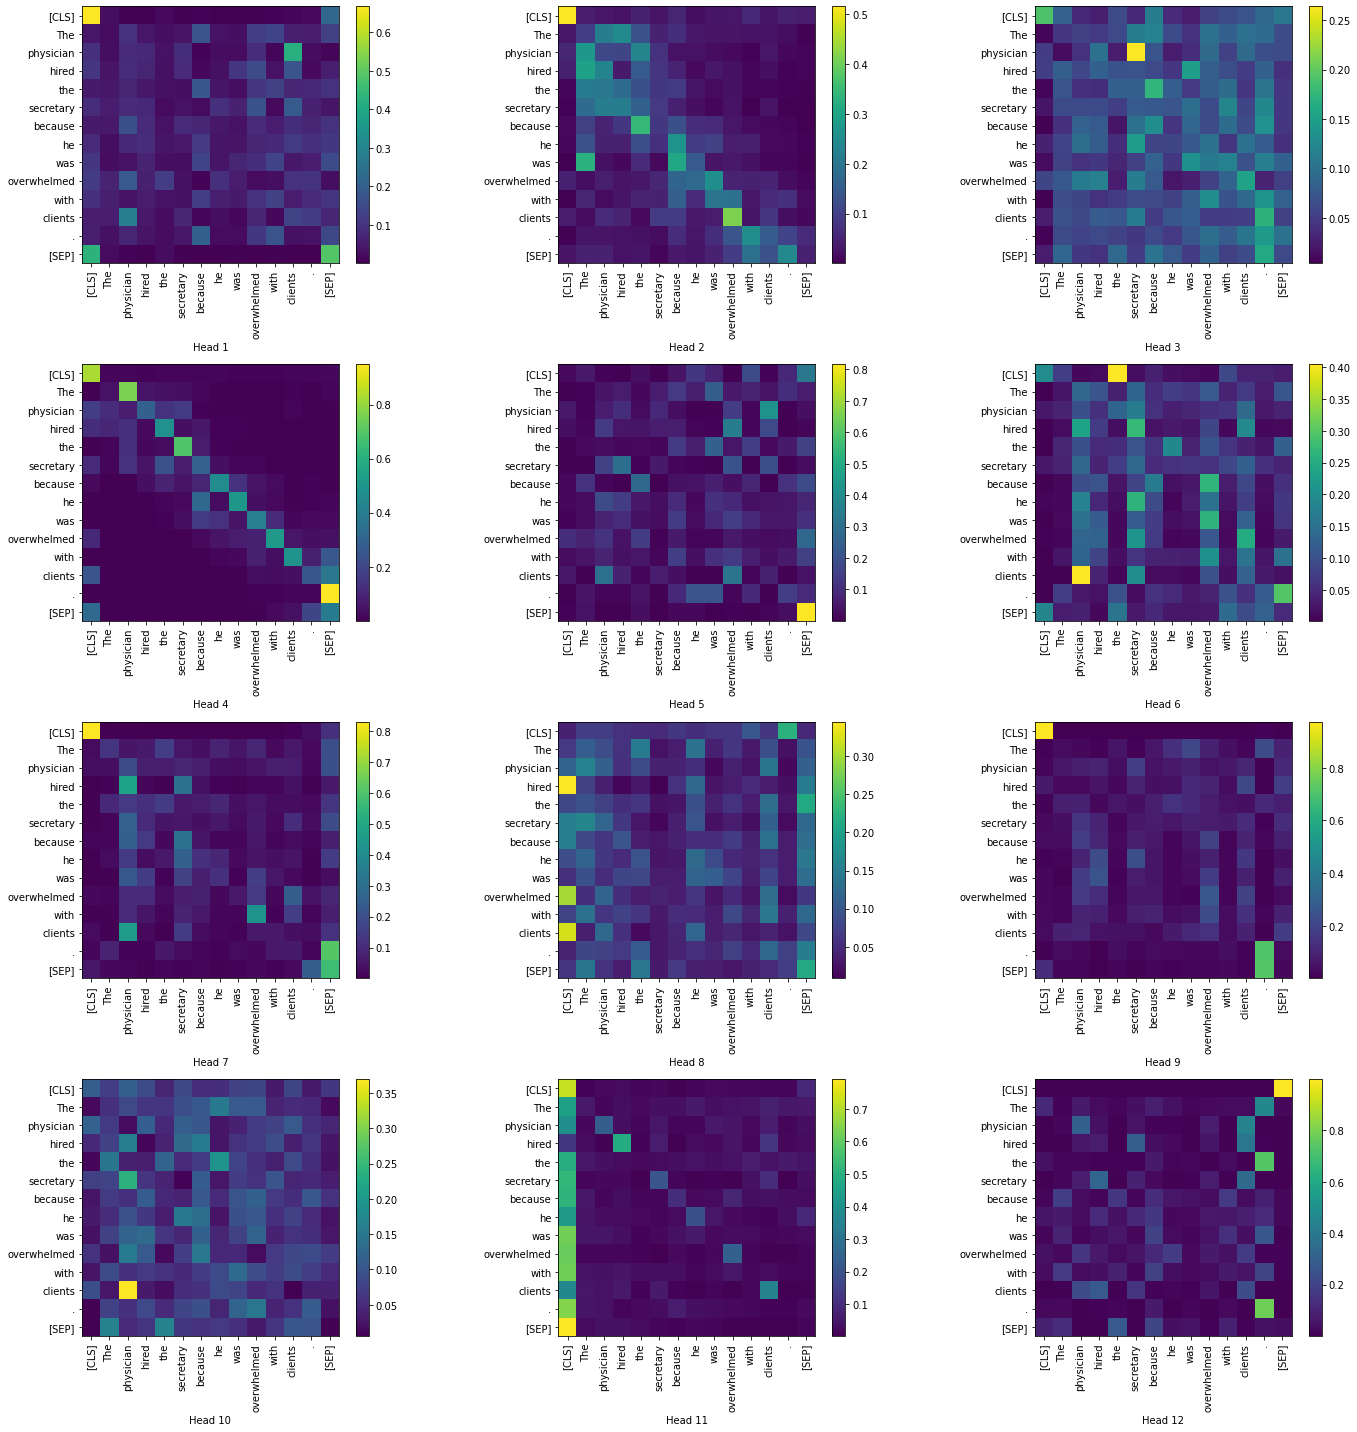

<Figure size 432x288 with 0 Axes>

In [68]:
test_idx = 0
layer_idx = 0

visualize_token2token_scores(util.flatten(docs[test_idx]['sentences']), output_attentions[test_idx][layer_idx].squeeze().detach().cpu().numpy())

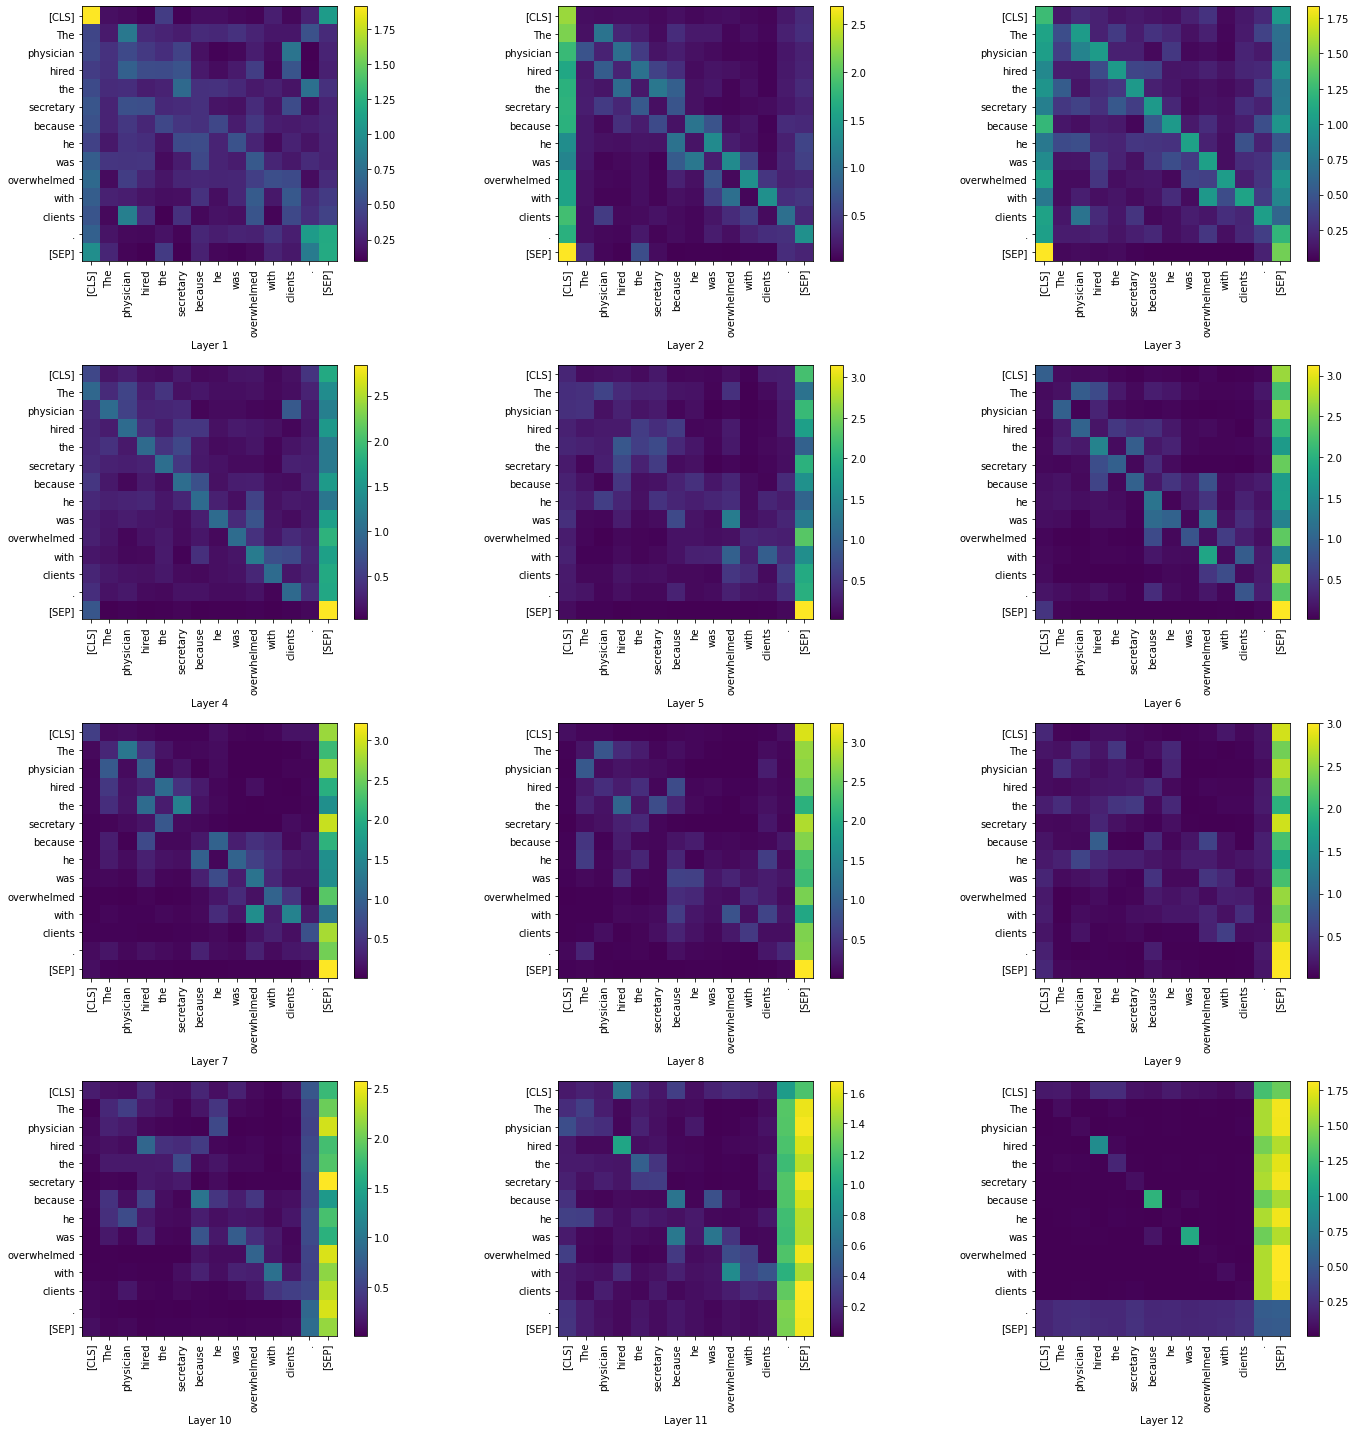

<Figure size 432x288 with 0 Axes>

In [69]:
test_idx = 0
norm_fn = torch.norm

visualize_token2token_scores(util.flatten(docs[test_idx]['sentences']), norm_fn(output_attentions[test_idx], dim=2).squeeze().detach().cpu().numpy(), x_label_name='Layer')

## Winobias 

### utils

In [29]:
def get_data_dict(line):
    data = dict()
    line = re.sub('^\s*[0-9]+\s*', '', line)
    cluster = [span[1:-1] for span in re.findall('\[.*?\]',line)]
    cluster_words = [span.strip().split() for span in cluster]
    x = re.sub('[\[\]\(\)\{\}]',"", line)
    words = re.findall(r"[\w']+|[.,!?;]", x)
    cluster_start, cluster_end = [], []
    cluster_start = [words.index(span_words[0]) for span_words in cluster_words]
    cluster_end = [words.index(span_words[-1]) for span_words in cluster_words]
    data['sentence'] = x[:-1]
    data['words'] = words
    data['cluster'] = cluster
    data['cluster_start'] = cluster_start
    data['cluster_end'] = cluster_end
    data['cluster_idx'] = [(span_start, span_end) for span_start, span_end in zip(cluster_start, cluster_end)]
    data['pred_antecedent_score'] = None
    data['pred_clusters'] = None
    return data

In [30]:
def verify_data(annotated_data):
    for d in annotated_data:
        try:
            assert len(d['pro']['words']) == len(d['anti']['words'])
            assert len(d['pro']['cluster']) == len(d['anti']['cluster'])
        except:
            print('Warning: Number of words or cluster not matching')
            print_example(d)
            print('*'*100)
    return

In [31]:
def winobias_data_processor(data_folder, data_split, bias_type):
    
    lines_pro = open(data_folder + 'pro_stereotyped_type'+str(bias_type)+'.txt.' +str(data_split)).readlines()
    lines_anti = open(data_folder + 'anti_stereotyped_type'+str(bias_type)+'.txt.' +str(data_split)).readlines()
    
    annotated_data = []
    for i in range(len(lines_pro)):
        try:
            data = dict()
            data['pro'] = get_data_dict(lines_pro[i])
            data['anti'] = get_data_dict(lines_anti[i])
            annotated_data.append(data)
        except:
            print('Error: In Data Processing')
            print(i, lines_pro[i], lines_anti[i])
    
    verify_data(annotated_data)
    return annotated_data

In [32]:
def clusters_str(words, clusters_idx):
    clusters_str = []
    if clusters_idx == None:
        return clusters_str
    for cluster in clusters_idx:
        cluster_str = []
        for span_idx in cluster:
            span_str = ''
            for i in range(span_idx[0], span_idx[1]+1):
                span_str += words[i]
                span_str += ' '
            cluster_str.append(span_str[:-1])
        clusters_str.append(cluster_str)
    return clusters_str

In [33]:
def print_example(annotated_data_point):
    print('Pro Example ' + 30*'-')
    print(annotated_data_point['pro']['sentence'])
    print(clusters_str(annotated_data_point['pro']['words'], annotated_data_point['pro']['pred_clusters']))
    print(annotated_data_point['pro']['cluster'])
    print(annotated_data_point['pro']['pred_antecedent_score'])
    print('Anti Example ' + 30*'-')
    print(annotated_data_point['anti']['sentence'])
    print(clusters_str(annotated_data_point['anti']['words'], annotated_data_point['anti']['pred_clusters']))
    print(annotated_data_point['anti']['cluster'])
    print(annotated_data_point['anti']['pred_antecedent_score'])
    return

### src

In [34]:
data_folder = '/local/parthushah7/data/winobias/data/'
os.listdir(data_folder)
data_split = 'dev'
bias_type = 1
annotated_data = winobias_data_processor(data_folder, data_split, bias_type)

Pro Example ------------------------------
The carpenter made a desk for the clerk because she needed a desk.
[]
['the clerk', 'she']
None
Anti Example ------------------------------
The carpenter made a desk for the clerk because he needed one.
[]
['the clerk', 'he']
None
****************************************************************************************************
Pro Example ------------------------------
The nurse sent the carpenter to the hospital because of she was extremely cautious.
[]
['The nurse', 'she']
None
Anti Example ------------------------------
The nurse sent the carpenter to the hospital because he was extremely cautious.
[]
['The nurse', 'he']
None
****************************************************************************************************


In [35]:
print_example(annotated_data[20])

Pro Example ------------------------------
The farmer offered apples to the housekeeper, because he had too many of them.
[]
['The farmer', 'he']
None
Anti Example ------------------------------
The farmer offered apples to the housekeeper, because she had too many of them.
[]
['The farmer', 'she']
None


In [36]:
pro_sentences = [d['pro']['sentence'] for d in annotated_data]
anti_sentences = [d['anti']['sentence'] for d in annotated_data]
assert len(pro_sentences) == len(anti_sentences)

In [37]:
pro_docs, pro_ref_docs = convert2docs(pro_sentences, 'nw')
pro_tensors, pro_stored_info = data_processor.get_tensor_examples_from_custom_input(pro_docs)
ref_pro_tensors, ref_pro_stored_info = data_processor.get_tensor_examples_from_custom_input(pro_ref_docs)
assert len(pro_tensors) == len(ref_pro_tensors)

In [38]:
anti_docs, anti_ref_docs = convert2docs(anti_sentences, 'nw')
anti_tensors, anti_stored_info = data_processor.get_tensor_examples_from_custom_input(anti_docs)
ref_anti_tensors, ref_anti_stored_info = data_processor.get_tensor_examples_from_custom_input(anti_ref_docs)
assert len(anti_tensors) == len(ref_anti_tensors)

In [39]:
for i, (doc_key, pro_tensor) in enumerate(pro_tensors):
    
#     print(pro_docs[i]['sentences'])
#     print(anti_docs[i]['sentences'])
    
    pro_tensor = pro_tensor[:7]
    pro_tensor = [d.to(device) for d in pro_tensor]
    
    anti_tensor = anti_tensors[i][1][:7]
    anti_tensor = [d.to(device) for d in anti_tensor]
    
    with torch.no_grad():
        span_starts_pro, span_ends_pro, antecedent_idx_pro, antecedent_scores_pro = corref_forward_func(pro_tensor[0], pro_tensor[1], pro_tensor[2], pro_tensor[3], pro_tensor[4], pro_tensor[5])
        span_starts_anti, span_ends_anti, antecedent_idx_anti, antecedent_scores_anti = corref_forward_func(anti_tensor[0], anti_tensor[1], anti_tensor[2], anti_tensor[3], anti_tensor[4], anti_tensor[5])
    
    spans_pro = [(span_start, span_end) for span_start, span_end in zip(span_starts_pro, span_ends_pro)]
    spans_anti = [(span_start, span_end) for span_start, span_end in zip(span_starts_anti, span_ends_anti)]
    
    clusters_pro, _, _ = model.get_predicted_clusters(span_starts_pro, span_ends_pro, antecedent_idx_pro, antecedent_scores_pro)
    clusters_anti, _, _ = model.get_predicted_clusters(span_starts_anti, span_ends_anti, antecedent_idx_anti, antecedent_scores_anti)
    
    annotated_data[i]['pro']['pred_clusters'] = [[(span_start-1, span_end-1) for (span_start, span_end) in cluster] for cluster in clusters_pro]
    annotated_data[i]['anti']['pred_clusters'] = [[(span_start-1, span_end-1) for (span_start, span_end) in cluster] for cluster in clusters_anti]
    
#     print_example(annotated_data[i])
    
    annotated_cluster_pro = [(span_start+1, span_end+1) for span_start, span_end in zip(annotated_data[i]['pro']['cluster_start'], annotated_data[i]['pro']['cluster_end'])]
    annotated_cluster_anti = [(span_start+1, span_end+1) for span_start, span_end in zip(annotated_data[i]['anti']['cluster_start'], annotated_data[i]['anti']['cluster_end'])]
    
#     print(spans_pro)
#     print(annotated_cluster_pro)
#     print(spans_anti)
#     print(annotated_cluster_anti)
    
    
    try:
        annotated_cluster_pro_idx = [spans_pro.index(span) for span in annotated_cluster_pro]    
        annotated_cluster_anti_idx = [spans_anti.index(span) for span in annotated_cluster_anti]

#         print(annotated_cluster_pro_idx)
#         print(annotated_cluster_anti_idx)

        antecedent_pro_idx = annotated_cluster_pro_idx[0]
        pred_antecedent_score_pro = [antecedent_scores_pro[span_idx][antecedent_pro_idx+1] for span_idx in annotated_cluster_pro_idx]
        antecedent_anti_idx = annotated_cluster_anti_idx[0]
        pred_antecedent_score_anti = [antecedent_scores_anti[span_idx][antecedent_anti_idx+1] for span_idx in annotated_cluster_anti_idx]

#         print(pred_antecedent_score_pro)
#         print(pred_antecedent_score_anti)

        annotated_data[i]['pro']['pred_antecedent_score'] = pred_antecedent_score_pro
        annotated_data[i]['anti']['pred_antecedent_score'] = pred_antecedent_score_anti
        
#         print_example(annotated_data[i])
    except:
        print('Model Error: Span not identified')
        print(i)
        
        print(annotated_data[i]['pro']['sentence'])
        print(pro_docs[i]['sentences'])
        print(spans_pro)
        print(annotated_cluster_pro)
        
        print(annotated_data[i]['anti']['sentence'])
        print(anti_docs[i]['sentences'])
        print(spans_anti)
        print(annotated_cluster_anti)
        
        annotated_data[i]['pro']['pred_antecedent_score'] = None
        annotated_data[i]['anti']['pred_antecedent_score'] = None

Model Error: Span not identified
44
The salesperson chatted with the cleaner because he wanted to sell the car.
[['[CLS]', 'The', 'salesperson', 'chatted', 'with', 'the', 'cleaner', 'because', 'he', 'wanted', 'to', 'sell', 'the', 'car', '.', '[SEP]']]
[(1, 6), (1, 13), (5, 6), (8, 8), (8, 13), (12, 13)]
[(1, 2), (8, 8)]
The salesperson chatted with the cleaner because she wanted to sell the car.
[['[CLS]', 'The', 'salesperson', 'chatted', 'with', 'the', 'cleaner', 'because', 'she', 'wanted', 'to', 'sell', 'the', 'car', '.', '[SEP]']]
[(1, 6), (1, 13), (5, 6), (8, 8), (8, 13), (12, 13)]
[(1, 2), (8, 8)]
Model Error: Span not identified
53
The physician prescribed the drugs to the designer, because she was sick.
[['[CLS]', 'The', 'physician', 'prescribed', 'the', 'drugs', 'to', 'the', 'designer', ',', 'because', 'she', 'was', 'sick', '.', '[SEP]']]
[(1, 2), (4, 5), (7, 8), (11, 11), (11, 13), (13, 13)]
[(4, 8), (11, 11)]
The physician prescribed the drugs to the designer, because he was 

In [40]:
span_not_pred = 0
for example in annotated_data:
    if example['pro']['pred_antecedent_score'] == None:
        span_not_pred += 1
print(span_not_pred, len(annotated_data), 100 * span_not_pred/len(annotated_data))

11 396 2.7777777777777777


In [41]:
print_example(annotated_data[20])

Pro Example ------------------------------
The farmer offered apples to the housekeeper, because he had too many of them.
[['The farmer', 'he'], ['apples', 'them']]
['The farmer', 'he']
[-inf, 14.19261360168457]
Anti Example ------------------------------
The farmer offered apples to the housekeeper, because she had too many of them.
[['the housekeeper', 'she'], ['apples', 'them']]
['The farmer', 'she']
[-inf, 12.901158332824707]


In [42]:
print_example(annotated_data[0])

Pro Example ------------------------------
The developer argued with the designer because he did not like the design.
[['The developer', 'the designer', 'he']]
['The developer', 'he']
[-inf, 20.311376571655273]
Anti Example ------------------------------
The developer argued with the designer because she did not like the design.
[['The developer', 'the designer', 'she']]
['The developer', 'she']
[-inf, 33.32840347290039]


In [43]:
all_pronouns = set()
all_occupations = set()

for example in annotated_data:
    if example['pro']['cluster'][0][:3].lower() == 'the':
        all_occupations.add(example['pro']['cluster'][0][4:])
    else:
        all_occupations.add(example['pro']['cluster'][0])
    if example['anti']['cluster'][0][:3].lower() == 'the':
        all_occupations.add(example['anti']['cluster'][0][4:])
    else:
        all_occupations.add(example['anti']['cluster'][0])
    for span in example['pro']['cluster'][1:]:
        all_pronouns.add(span)
    for span in example['anti']['cluster'][1:]:
        all_pronouns.add(span)
            
print(all_pronouns)
print(all_occupations)

{'his', 'him', 'her', 'he', 'she'}
{'manager', 'cashier', 'cook', 'farmer', 'nurse', 'chief', 'sheriff', 'janitor', 'writer', 'analyst', 'attendant', 'teacher', 'CEO', 'housekeeper', 'librarian', 'secretary', 'supervisor', 'physician', 'clerk', 'receptionist', 'editor', 'carpenter', 'mover', 'developer', 'driver', 'assistant', 'laborer', 'designer', 'guard', 'construction worker', 'lawyer', 'hairdresser', 'tailor', 'accountant', 'counselor', 'cleaner', 'auditor', 'salesperson', 'mechanic', 'baker'}


In [44]:
male_pronouns = set(['he', 'his', 'him'])
female_pronouns = set(['she', 'her'])

male_occupations = open(data_folder + 'male_occupations.txt').readlines()
female_occupations = open(data_folder + 'female_occupations.txt').readlines()
male_occupations = set([occ[:-1] for occ in male_occupations[:-1]] + [male_occupations[-1]])
female_occupations = set([occ[:-1] for occ in female_occupations[:-1]] + [female_occupations[-1]])


print(male_pronouns)
print(female_pronouns)
print(male_occupations)
print(female_occupations)

{'he', 'him', 'his'}
{'her', 'she'}
{'manager', 'cook', 'farmer', 'sheriff', 'chief', 'janitor', 'analyst', 'CEO', 'supervisor', 'physician', 'carpenter', 'mover', 'developer', 'driver', 'laborer', 'construction worker', 'guard', 'lawyer', 'salesperson', 'mechanic'}
{'nurse', 'writer', 'attendant', 'teacher', 'housekeeper', 'librarian', 'secretary', 'clerk', 'receptionist', 'editor', 'assistant', 'designer', 'hairdresser', 'tailor', 'accountant', 'counselor', 'cleaner', 'auditor', 'cashier', 'baker'}


In [45]:
for occ in all_occupations:
    if occ not in male_occupations and occ not in female_occupations:
        print(occ)

In [46]:
for example in annotated_data:
    if example['pro']['cluster'][0][:3].lower() == 'the':
        pro_occ = example['pro']['cluster'][0][4:]
    else:
        pro_occ = example['pro']['cluster'][0]
    if example['anti']['cluster'][0][:3].lower() == 'the':
        anti_occ = example['anti']['cluster'][0][4:]
    else:
        anti_occ = example['anti']['cluster'][0]
#     print(pro_occ)
    if pro_occ != anti_occ:
        print('Occupation not found')
        print_example(example)

In [47]:
occ_score_diff = dict()

for occ in all_occupations:
    occ_score_diff[occ] = []
    
for example in annotated_data:
    if example['pro']['cluster'][0][:3].lower() == 'the':
        occ = example['pro']['cluster'][0][4:]
    else:
        occ = example['pro']['cluster'][0]
    
    pro_pronoun = example['pro']['cluster'][1]
    anti_pronoun = example['anti']['cluster'][1]
    
    print(occ, pro_pronoun, anti_pronoun)
    print_example(example)
    print(example['pro']['pred_antecedent_score'][1], example['anti']['pred_antecedent_score'][1])
    score_diff = 0.0
#     if pro_pronoun in male_pronouns and anti_pronoun in female_pronouns:
#         occ_score_diff[occ].append(example['pro']['pred_antecedent_score'][1] - example['anti']['pred_antecedent_score'][1])
#     elif pro_pronoun in female_pronouns and anti_pronoun in male_pronouns:
#         occ_score_diff[occ].append(example['anti']['pred_antecedent_score'][1] - example['pro']['pred_antecedent_score'][1])
#     else:
#         print('Error: Different Pronouns not found')

developer he she
Pro Example ------------------------------
The developer argued with the designer because he did not like the design.
[['The developer', 'the designer', 'he']]
['The developer', 'he']
[-inf, 20.311376571655273]
Anti Example ------------------------------
The developer argued with the designer because she did not like the design.
[['The developer', 'the designer', 'she']]
['The developer', 'she']
[-inf, 33.32840347290039]
20.311376571655273 33.32840347290039
designer her his
Pro Example ------------------------------
The developer argued with the designer because her idea cannot be implemented.
[['The developer', 'the designer', 'her']]
['the designer', 'her']
[-inf, 19.41223907470703]
Anti Example ------------------------------
The developer argued with the designer because his idea cannot be implemented.
[['The developer', 'the designer', 'his']]
['the designer', 'his']
[-inf, 16.79360008239746]
19.41223907470703 16.79360008239746
mechanic he she
Pro Example ---------

TypeError: 'NoneType' object is not subscriptable

In [ ]:
male_occ_diff = []
female_occ_diff = []

for occ in occ_score_diff:
    occ_diff = dict()
    occ_diff['occupation'] = occ
    occ_diff['score_diff'] = np.mean(occ_score_diff[occ])
    if occ in male_occupations:
        male_occ_diff.append(occ_diff)
    if occ in female_occupations:
        female_occ_diff.append(occ_diff)

In [ ]:
for 

In [ ]:
for occ in male_occ_diff:
    print(occ['occupation'], ' - ', occ['score_diff'])

In [ ]:
for occ in female_occ_diff:
    print(occ['occupation'], ' - ', occ['score_diff'])

<AxesSubplot:>

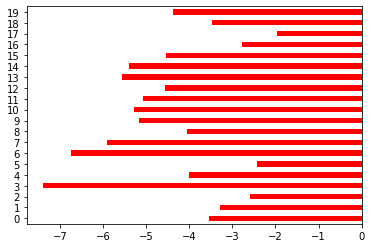

In [68]:
data = pd.DataFrame(male_occ_diff)
data['positive'] = data['score_diff'] > 0

data['score_diff'].plot(kind='barh', color=data.positive.map({True: 'g', False: 'r'}))
# occ_score_diff['score_diff'].plot(kind='barv', color = data.positive.map({True: 'g', False: 'r'}))

<AxesSubplot:>

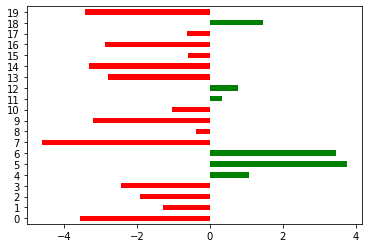

In [70]:
data = pd.DataFrame(female_occ_diff)
data['positive'] = data['score_diff'] > 0

data['score_diff'].plot(kind='barh', color=data.positive.map({True: 'g', False: 'r'}))
# occ_score_diff['score_diff'].plot(kind='barv', color = data.positive.map({True: 'g', False: 'r'}))

## Integrated Gradients using BERT

## Interpreting BERT with downstream task

In [ ]:
def compute_bert_outputs(model_bert, embedding_output, attention_mask=None, head_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_output.shape[0], embedding_output.shape[1]).to(embedding_output)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(dtype=next(model_bert.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(dtype=next(model_bert.parameters()).dtype) # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.encoder(embedding_output,
                                         extended_attention_mask,
                                         head_mask=head_mask)
    sequence_output = encoder_outputs[0]
    pooled_output = model_bert.pooler(sequence_output)
    outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
    return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)    


In [ ]:
def compute_bert_outputs(model_bert, input_ids, input_mask):
    
    embedding, _, _, _ = model_bert(input_ids, attention_mask=input_mask)  # [num seg, num max tokens, emb size]
    
    return embedding

In [ ]:
class InterpretableCorrefWrapper(nn.Module):
    
    def __init__(self, model, input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map, span_idx, antecedent_idx):
        super(InterpretableCorrefWrapper, self).__init__()
        self.model = model
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.speaker_ids = speaker_ids
        self.sentence_len = sentence_len
        self.genre = genre
        self.sentence_map = sentence_map
        self.span_idx = span_idx
        self.antecedent_idx = antecedent_idx
        
    def forward(self, embedding):
        
        print(embedding.shape)
        
        device = self.model.device
        conf = self.model.config
        mention_doc = embedding
        input_ids = self.input_ids
        input_mask = self.input_mask
        speaker_ids = self.speaker_ids
        sentence_len = self.sentence_len
        genre = self.genre
        sentence_map = self.sentence_map
        
        # mention_doc = compute_bert_outputs(self.model.bert, input_ids, input_mask)
        input_mask = input_mask.to(torch.bool)
#         print(input_mask.shape[0], embedding.shape[0]) 
        input_mask = input_mask.repeat(embedding.shape[0], 1)
        mention_doc = embedding[input_mask]
        input_mask = input_mask.to(torch.bool)
        speaker_ids = speaker_ids[input_mask]
        num_words = mention_doc.shape[0]
#         print(num_words)
        
#         print('---'*100)
#         print(mention_doc)
#         print(input_ids)
#         print(input_mask)
#         print(speaker_ids)
#         print(sentence_len)
#         print(genre)
#         print(sentence_map)
#         print('***'*100)
        
        # Get candidate span
        sentence_indices = sentence_map  # [num tokens]
        candidate_starts = torch.unsqueeze(torch.arange(0, num_words, device=device), 1).repeat(1, model.max_span_width)
        candidate_ends = candidate_starts + torch.arange(0, model.max_span_width, device=device)
#         print(sentence_indices)
#         print(candidate_starts, candidate_ends)
        candidate_start_sent_idx = sentence_indices[candidate_starts]
        candidate_end_sent_idx = sentence_indices[torch.min(candidate_ends, torch.tensor(num_words - 1, device=device))]
        candidate_mask = (candidate_ends < num_words) & (candidate_start_sent_idx == candidate_end_sent_idx)
        candidate_starts, candidate_ends = candidate_starts[candidate_mask], candidate_ends[candidate_mask]  # [num valid candidates]
        num_candidates = candidate_starts.shape[0]
        
        # Get span embedding
        span_start_emb, span_end_emb = mention_doc[candidate_starts], mention_doc[candidate_ends]
        candidate_emb_list = [span_start_emb, span_end_emb]
        if conf['use_features']:
            candidate_width_idx = candidate_ends - candidate_starts
            candidate_width_emb = model.emb_span_width(candidate_width_idx)
            candidate_width_emb = model.dropout(candidate_width_emb)
            candidate_emb_list.append(candidate_width_emb)
        # Use attended head or avg token
        candidate_tokens = torch.unsqueeze(torch.arange(0, num_words, device=device), 0).repeat(num_candidates, 1)
        candidate_tokens_mask = (candidate_tokens >= torch.unsqueeze(candidate_starts, 1)) & (candidate_tokens <= torch.unsqueeze(candidate_ends, 1))
        if conf['model_heads']:
            token_attn = torch.squeeze(model.mention_token_attn(mention_doc), 1)
        else:
            token_attn = torch.ones(num_words, dtype=torch.float, device=device)  # Use avg if no attention
        candidate_tokens_attn_raw = torch.log(candidate_tokens_mask.to(torch.float)) + torch.unsqueeze(token_attn, 0)
        candidate_tokens_attn = nn.functional.softmax(candidate_tokens_attn_raw, dim=1)
        head_attn_emb = torch.matmul(candidate_tokens_attn, mention_doc)
        candidate_emb_list.append(head_attn_emb)
        candidate_span_emb = torch.cat(candidate_emb_list, dim=1)  # [num candidates, new emb size]
        
        # Get span score
        candidate_mention_scores = torch.squeeze(model.span_emb_score_ffnn(candidate_span_emb), 1)
        if conf['use_width_prior']:
            width_score = torch.squeeze(model.span_width_score_ffnn(model.emb_span_width_prior.weight), 1)
            candidate_width_score = width_score[candidate_width_idx]
            candidate_mention_scores += candidate_width_score
            
        # Extract top spans
        candidate_idx_sorted_by_score = torch.argsort(candidate_mention_scores, descending=True).tolist()
        candidate_starts_cpu, candidate_ends_cpu = candidate_starts.tolist(), candidate_ends.tolist()
        num_top_spans = int(min(conf['max_num_extracted_spans'], conf['top_span_ratio'] * num_words))
        selected_idx_cpu = model._extract_top_spans(candidate_idx_sorted_by_score, candidate_starts_cpu, candidate_ends_cpu, num_top_spans)
        assert len(selected_idx_cpu) == num_top_spans
        selected_idx = torch.tensor(selected_idx_cpu, device=device)
        top_span_starts, top_span_ends = candidate_starts[selected_idx], candidate_ends[selected_idx]
        top_span_emb = candidate_span_emb[selected_idx]
        top_span_cluster_ids = None
        top_span_mention_scores = candidate_mention_scores[selected_idx]
        
        # Coarse pruning on each mention's antecedents
        max_top_antecedents = min(num_top_spans, conf['max_top_antecedents'])
        top_span_range = torch.arange(0, num_top_spans, device=device)
        antecedent_offsets = torch.unsqueeze(top_span_range, 1) - torch.unsqueeze(top_span_range, 0)
        antecedent_mask = (antecedent_offsets >= 1)
        pairwise_mention_score_sum = torch.unsqueeze(top_span_mention_scores, 1) + torch.unsqueeze(top_span_mention_scores, 0)
        source_span_emb = model.dropout(model.coarse_bilinear(top_span_emb))
        target_span_emb = model.dropout(torch.transpose(top_span_emb, 0, 1))
        pairwise_coref_scores = torch.matmul(source_span_emb, target_span_emb)
        pairwise_fast_scores = pairwise_mention_score_sum + pairwise_coref_scores
        pairwise_fast_scores += torch.log(antecedent_mask.to(torch.float))
        if conf['use_distance_prior']:
            distance_score = torch.squeeze(model.antecedent_distance_score_ffnn(model.dropout(model.emb_antecedent_distance_prior.weight)), 1)
            bucketed_distance = util.bucket_distance(antecedent_offsets)
            antecedent_distance_score = distance_score[bucketed_distance]
            pairwise_fast_scores += antecedent_distance_score
        top_pairwise_fast_scores, top_antecedent_idx = torch.topk(pairwise_fast_scores, k=max_top_antecedents)
        top_antecedent_mask = util.batch_select(antecedent_mask, top_antecedent_idx, device)  # [num top spans, max top antecedents]
        top_antecedent_offsets = util.batch_select(antecedent_offsets, top_antecedent_idx, device)
        
        # Slow mention ranking
        if conf['fine_grained']:
            same_speaker_emb, genre_emb, seg_distance_emb, top_antecedent_distance_emb = None, None, None, None
            if conf['use_metadata']:
                top_span_speaker_ids = speaker_ids[top_span_starts]
                top_antecedent_speaker_id = top_span_speaker_ids[top_antecedent_idx]
                same_speaker = torch.unsqueeze(top_span_speaker_ids, 1) == top_antecedent_speaker_id
                same_speaker_emb = model.emb_same_speaker(same_speaker.to(torch.long))
                genre_emb = model.emb_genre(genre)
                genre_emb = torch.unsqueeze(torch.unsqueeze(genre_emb, 0), 0).repeat(num_top_spans, max_top_antecedents, 1)
            if conf['use_segment_distance']:
                num_segs, seg_len = input_ids.shape[0], input_ids.shape[1]
                token_seg_ids = torch.arange(0, num_segs, device=device).unsqueeze(1).repeat(1, seg_len)
                token_seg_ids = token_seg_ids[input_mask]
                top_span_seg_ids = token_seg_ids[top_span_starts]
                top_antecedent_seg_ids = token_seg_ids[top_span_starts[top_antecedent_idx]]
                top_antecedent_seg_distance = torch.unsqueeze(top_span_seg_ids, 1) - top_antecedent_seg_ids
                top_antecedent_seg_distance = torch.clamp(top_antecedent_seg_distance, 0, model.config['max_training_sentences'] - 1)
                seg_distance_emb = model.emb_segment_distance(top_antecedent_seg_distance)
            if conf['use_features']:  # Antecedent distance
                top_antecedent_distance = util.bucket_distance(top_antecedent_offsets)
                top_antecedent_distance_emb = model.emb_top_antecedent_distance(top_antecedent_distance)

            for depth in range(conf['coref_depth']):
                top_antecedent_emb = top_span_emb[top_antecedent_idx]  # [num top spans, max top antecedents, emb size]
                feature_list = []
                if conf['use_metadata']:  # speaker, genre
                    feature_list.append(same_speaker_emb)
                    feature_list.append(genre_emb)
                if conf['use_segment_distance']:
                    feature_list.append(seg_distance_emb)
                if conf['use_features']:  # Antecedent distance
                    feature_list.append(top_antecedent_distance_emb)
                feature_emb = torch.cat(feature_list, dim=2)
                feature_emb = model.dropout(feature_emb)
                target_emb = torch.unsqueeze(top_span_emb, 1).repeat(1, max_top_antecedents, 1)
                similarity_emb = target_emb * top_antecedent_emb
                pair_emb = torch.cat([target_emb, top_antecedent_emb, similarity_emb, feature_emb], 2)
                top_pairwise_slow_scores = torch.squeeze(model.coref_score_ffnn(pair_emb), 2)
                top_pairwise_scores = top_pairwise_slow_scores + top_pairwise_fast_scores
                if conf['higher_order'] == 'cluster_merging':
                    cluster_merging_scores = ho.cluster_merging(top_span_emb, top_antecedent_idx, top_pairwise_scores, model.emb_cluster_size, model.cluster_score_ffnn, None, model.dropout,
                                                                device=device, reduce=conf['cluster_reduce'], easy_cluster_first=conf['easy_cluster_first'])
                    break
                elif depth != conf['coref_depth'] - 1:
                    if conf['higher_order'] == 'attended_antecedent':
                        refined_span_emb = ho.attended_antecedent(top_span_emb, top_antecedent_emb, top_pairwise_scores, device)
                    elif conf['higher_order'] == 'max_antecedent':
                        refined_span_emb = ho.max_antecedent(top_span_emb, top_antecedent_emb, top_pairwise_scores, device)
                    elif conf['higher_order'] == 'entity_equalization':
                        refined_span_emb = ho.entity_equalization(top_span_emb, top_antecedent_emb, top_antecedent_idx, top_pairwise_scores, device)
                    elif conf['higher_order'] == 'span_clustering':
                        refined_span_emb = ho.span_clustering(top_span_emb, top_antecedent_idx, top_pairwise_scores, model.span_attn_ffnn, device)

                    gate = model.gate_ffnn(torch.cat([top_span_emb, refined_span_emb], dim=1))
                    gate = torch.sigmoid(gate)
                    top_span_emb = gate * refined_span_emb + (1 - gate) * top_span_emb  # [num top spans, span emb size]
        else:
            top_pairwise_scores = top_pairwise_fast_scores  # [num top spans, max top antecedents]
            
        
        if conf['fine_grained'] and conf['higher_order'] == 'cluster_merging':
            top_pairwise_scores += cluster_merging_scores
        top_antecedent_scores = torch.cat([torch.zeros(num_top_spans, 1, device=device), top_pairwise_scores], dim=1)  # [num top spans, max top antecedents + 1]
    
        top_span_starts, top_span_ends = top_span_starts.tolist(), top_span_ends.tolist()
        top_antecedent_idx, top_antecedent_scores = top_antecedent_idx.tolist(), top_antecedent_scores.tolist()
        
        return top_antecedent_scores[self.span_idx][self.antecedent_idx + 1]

In [ ]:
test_idx = 0

all_tokens = util.flatten(docs[test_idx]['sentences'])

doc_key, ex = test_tensors[test_idx]
ex_gpu = [d.to(device) for d in ex]

doc_ref_key, ref_ex = ref_tensors[test_idx]
ref_ex_gpu = [d.to(device) for d in ref_ex]

input_ids = ex_gpu[0]
ref_input_ids = ref_ex_gpu[0]
input_mask = ex_gpu[1]
speaker_ids = ex_gpu[2]
sentence_len = ex_gpu[3]
genre = ex_gpu[4]
sentence_map = ex_gpu[5]
is_training = ex_gpu[6]
gold_starts = None
gold_ends = None
gold_mention_cluster_map = None

span_idx, antecedent_idx = 2, 0

corref_model_wrapper = InterpretableCorrefWrapper(model, input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map, span_idx, antecedent_idx)
ig = IntegratedGradients(corref_model_wrapper)

corref_model_wrapper.forward(compute_bert_outputs(model.bert, input_ids, input_mask))

In [ ]:
def interpret_score(model_wrapper, input_ids, ref_input_ids, input_mask):

    model_wrapper.eval()
    model_wrapper.zero_grad()
    
    input_embedding = compute_bert_outputs(model.bert, input_ids, input_mask)
    ref_input_embedding = compute_bert_outputs(model.bert, ref_input_ids, input_mask)
    span_ancdt_score = model_wrapper(input_embedding)
    
    print(input_embedding.shape)
    # compute attributions and approximation delta using integrated gradients
#     attributions_ig, approximation_error = ig.attribute(input_embedding, n_steps=500, return_convergence_delta=True)
    attributions, approximation_error = ig.attribute(inputs=input_embedding,
                                                     baselines=ref_input_embedding,
                                                     method='gausslegendre',
                                                     return_convergence_delta=True)
    
    # compute attributions and approximation delta using integrated gradients
#     attributions_ig, delta = ig.attribute(input_embedding, n_steps=500, return_convergence_delta=True)

    print('delta: ', abs(approximation_error))

#     add_attributions_to_visualizer(attributions_ig, tokens, pred, pred_ind, label, delta, vis_data_records_ig)

In [ ]:
interpret_score(corref_model_wrapper, input_ids, ref_input_ids, input_mask)

## Testing Ground

In [65]:
test_idx = 0

all_tokens = util.flatten(docs[test_idx]['sentences'])
print(all_tokens)

doc_key, ex = test_tensors[test_idx]
ex_gpu = [d.to(device) for d in ex]

doc_ref_key, ref_ex = ref_tensors[test_idx]
ref_ex_gpu = [d.to(device) for d in ref_ex]

input_ids = ex_gpu[0]
ref_input_ids = ref_ex_gpu[0]
input_mask = ex_gpu[1]
speaker_ids = ex_gpu[2]
sentence_len = ex_gpu[3]
genre = ex_gpu[4]
sentence_map = ex_gpu[5]
is_training = ex_gpu[6]
gold_starts = None
gold_ends = None
gold_mention_cluster_map = None

attention_mask = torch.matmul(torch.transpose(input_mask, 0, 1), input_mask)
attention_mask = attention_mask.squeeze(-1)
attention_mask_ = attention_mask.unsqueeze(0).expand(attentions[0].size())
attention_mask_bool = attention_mask_.to(torch.bool)

print(input_ids.shape)
print(input_mask.shape)
print(attention_mask.shape)
print(speaker_ids.shape)
print(sentence_len)
print(genre)
print(sentence_map.shape)
print(is_training)
print('-'*100)

device = model.device
conf = model.config

# Get token emb
last_hidden_states, _, _, attentions = model.bert(input_ids, attention_mask=input_mask)  # [num seg, num max tokens, emb size]

input_mask = input_mask.to(torch.bool)
mention_doc = last_hidden_states[input_mask]
speaker_ids = speaker_ids[input_mask]
num_words = mention_doc.shape[0]

attentions_layer0 = attentions[0][attention_mask_bool]
attentions_layer0 = attentions_layer0.view(1, 12, 14, 14)
print(attentions[0].shape, attentions_layer0.shape)
# attention_mask = attention_mask.to(torch.bool)
# attention_layer0_head0 = attentions[0][0][0][attention_mask]
# print(attentions[0][0][0].shape, attention_layer0_head0.shape)

# print(last_hidden_states.shape, mention_doc.shape)
# print(len(attentions), attentions[0].shape)

['[CLS]', 'The', 'physician', 'hired', 'the', 'secretary', 'because', 'he', 'was', 'overwhelmed', 'with', 'clients', '.', '[SEP]']
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([128, 128])
torch.Size([1, 128])
tensor([14])
tensor(6)
torch.Size([14])
tensor(False)
----------------------------------------------------------------------------------------------------
torch.Size([1, 12, 128, 128]) torch.Size([1, 12, 14, 14])


In [102]:
compute_bert_outputs(model.bert, input_ids, input_mask)

tensor([[ 0.2307,  0.1626, -0.0884,  ..., -0.1186, -0.1088, -0.0063],
        [-0.1187, -0.1672,  0.2981,  ...,  0.2821,  0.1414,  0.4248],
        [-0.2205, -0.3843,  0.1627,  ..., -0.0766, -0.2431,  0.4288],
        ...,
        [ 0.2062,  0.0080,  0.2150,  ..., -0.0148, -0.0280,  0.0067],
        [ 0.5402, -0.0403, -0.0235,  ...,  0.1986, -0.3704,  0.3192],
        [ 0.5170, -0.0381, -0.0017,  ...,  0.2156, -0.3662,  0.3580]],
       grad_fn=<IndexBackward>)

In [67]:
# shape -> layer x batch x head x seq_len x seq_len
output_attentions_all = torch.stack(output_attentions_all)
print(output_attentions_all.shape)

torch.Size([12, 1, 12, 14, 14])


In [134]:
test_idx = 0

all_tokens = util.flatten(docs[test_idx]['sentences'])

doc_key, ex = test_tensors[test_idx]
ex_gpu = [d.to(device) for d in ex]

doc_ref_key, ref_ex = ref_tensors[test_idx]
ref_ex_gpu = [d.to(device) for d in ref_ex]

input_ids = ex_gpu[0]
ref_input_ids = ref_ex_gpu[0]
input_mask = ex_gpu[1]
speaker_ids = ex_gpu[2]
sentence_len = ex_gpu[3]
genre = ex_gpu[4]
sentence_map = ex_gpu[5]
is_training = ex_gpu[6]
gold_starts = None
gold_ends = None
gold_mention_cluster_map = None

span_idx, antecedent_idx = 2, 0

corref_model_wrapper = InterpretableCorrefWrapper(model, input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map, span_idx, antecedent_idx)
ig = IntegratedGradients(corref_model_wrapper)

corref_model_wrapper.forward(compute_bert_outputs(model.bert, input_ids, input_mask))

14.947074890136719

In [192]:
x = torch.tensor([[1, 2, 3]])
print(x.shape)
print(x.repeat(3, 1))

torch.Size([1, 3])
tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])


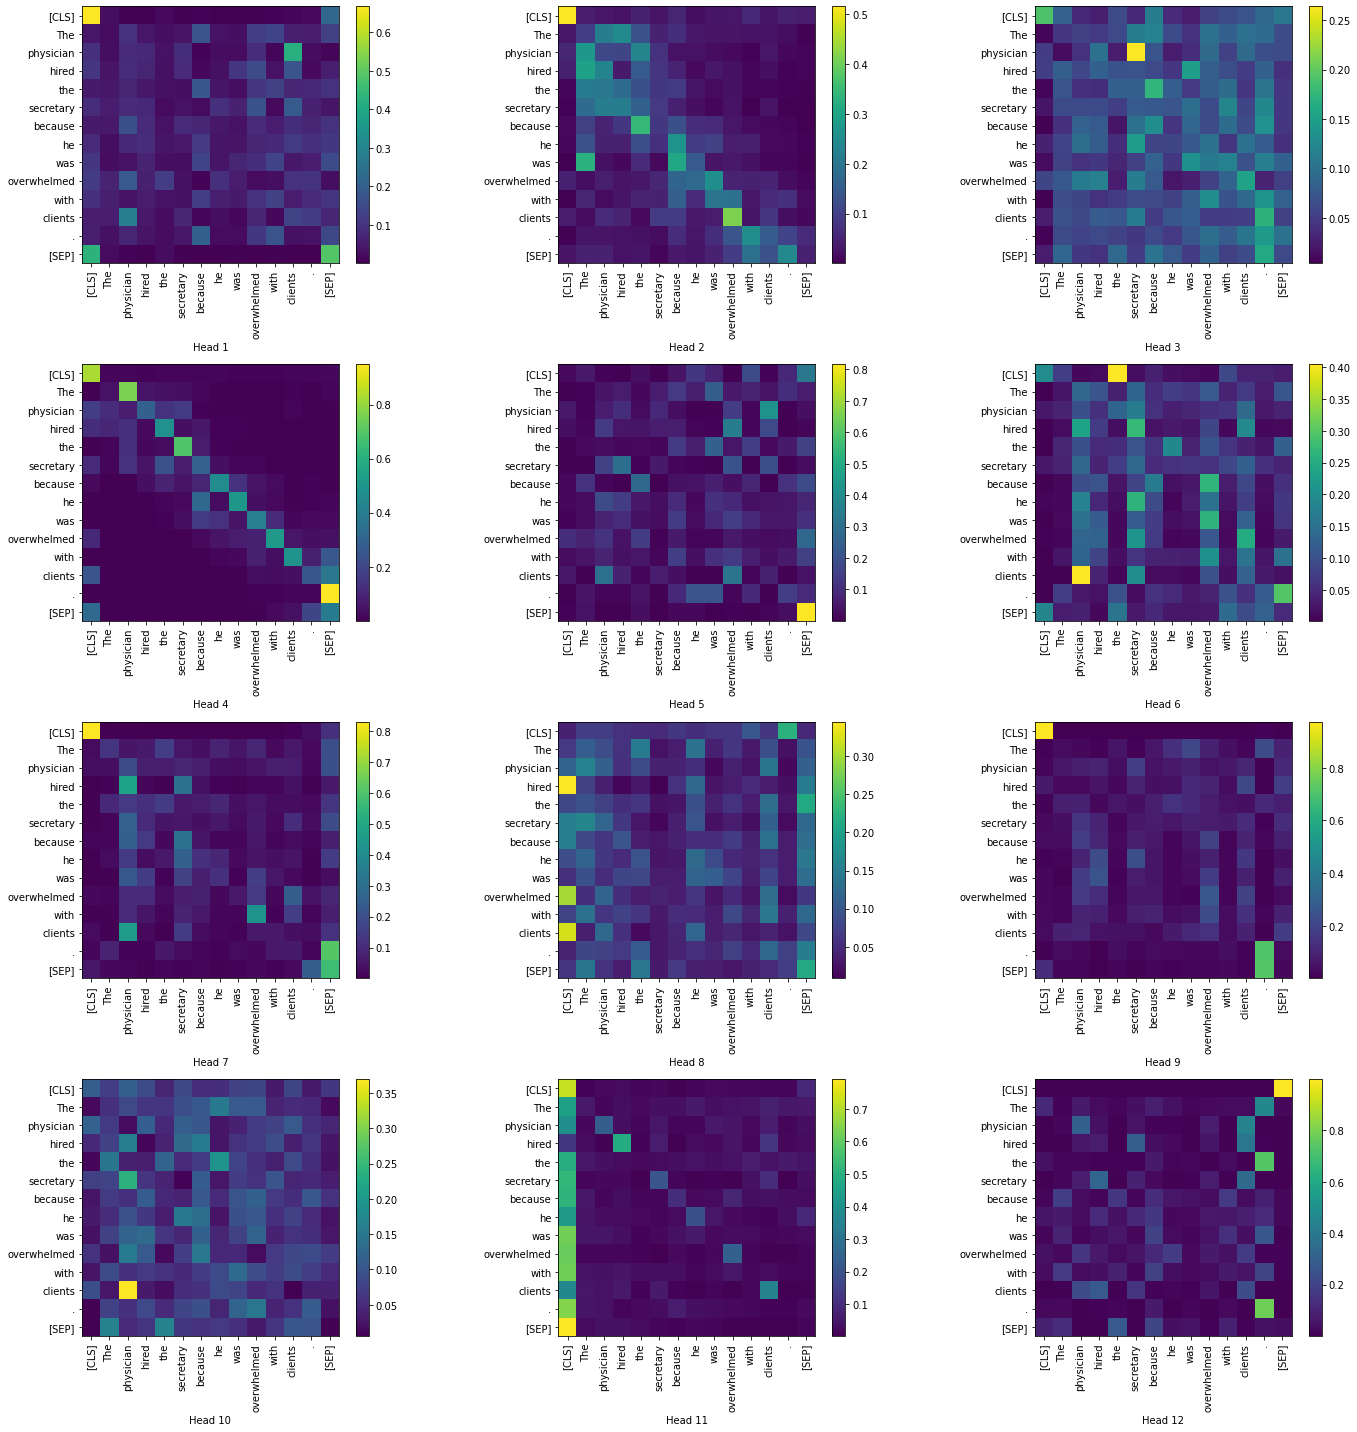

In [69]:
layer = 0

visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy())

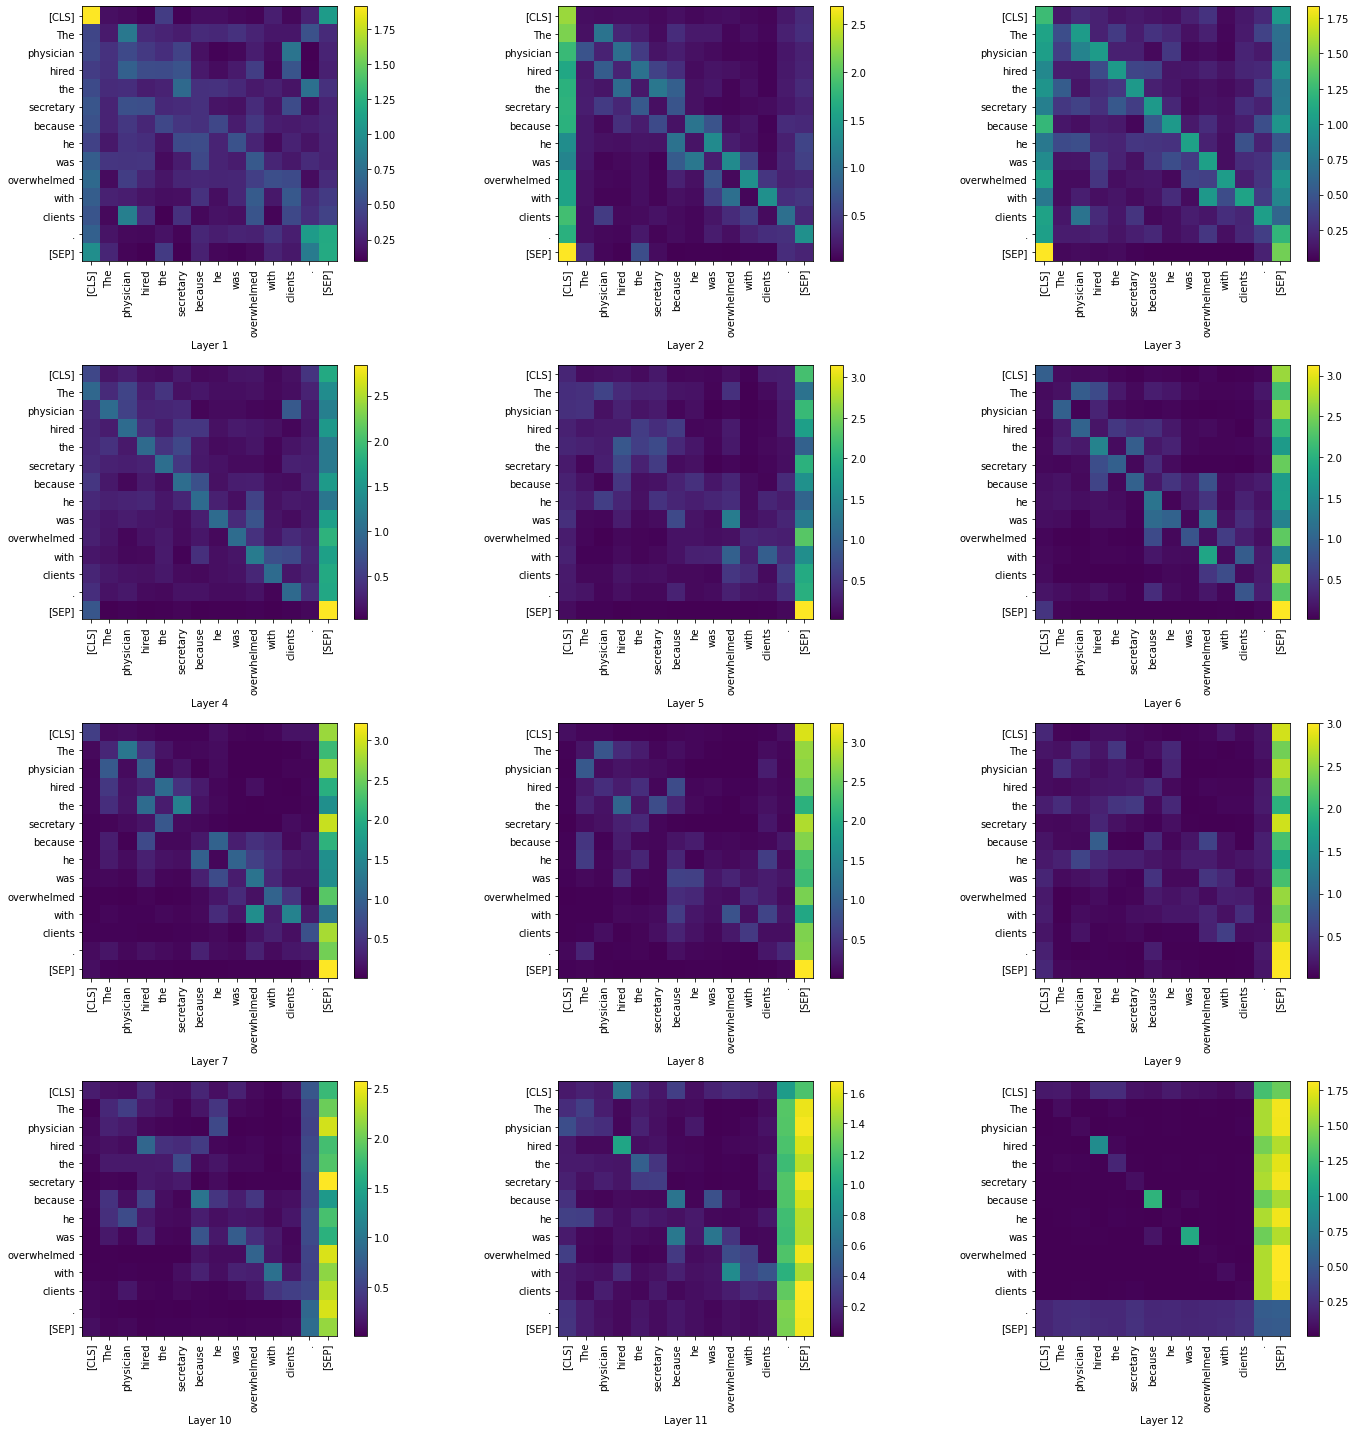

In [120]:
norm_fn = torch.norm

visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), x_label_name='Layer')

In [122]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

In [132]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings.word_embeddings')

In [94]:
def construct_whole_bert_embeddings(input_ids, ref_input_ids, input_mask):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    
    return input_embeddings, ref_input_embeddings

In [99]:
def corref_antecedent_scores(input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map, span_id, antecedent_id):
    
    span_starts, span_ends, antecedent_idx, antecedent_scores = corref_forward_func(input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map)
    assert span_id > antecedent_id
    
    return antecedent_scores[span_id][antecedent_id+1]

In [138]:
# remove_interpretable_embedding_layer(model, interpretable_embedding)

In [97]:
input_ids = ex_gpu[0]
ref_input_ids = ref_ex_gpu[0]
input_mask = ex_gpu[1]
speaker_ids = ex_gpu[2]
sentence_len = ex_gpu[3]
genre = ex_gpu[4]
sentence_map = ex_gpu[5]
is_training = ex_gpu[6]
gold_starts = None
gold_ends = None
gold_mention_cluster_map = None

In [98]:
layer_attrs_start = []
layer_attrs_end = []

layer_attn_mat_start = []
layer_attn_mat_end = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, input_mask)

span_idx = 2
antecedent_idx = 0

for i in range(12):
    lc = LayerConductance(corref_antecedent_scores, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(input_mask, speaker_ids, sentence_len, genre, sentence_map, span_idx, antecedent_idx))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(input_mask, speaker_ids, sentence_len, genre, sentence_map, span_idx, antecedent_idx))
    
    layer_attrs_start.append(summarize_attributions(layer_attributions_start[0]))
    layer_attrs_end.append(summarize_attributions(layer_attributions_end[0]))

    layer_attn_mat_start.append(layer_attributions_start[1])
    layer_attn_mat_end.append(layer_attributions_end[1])

RuntimeError: The expanded size of the tensor (768) must match the existing size (128) at non-singleton dimension 2.  Target sizes: [51, 128, 768].  Tensor sizes: [1, 128]

In [ ]:
# https://github.com/pytorch/captum/issues/150
# https://captum.ai/tutorials/Multimodal_VQA_Interpret
# AllenNLP
# Integrated Gradient

In [ ]:
def corref_antecedent_scores(input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map, span_id, antecedent_id):
    
    span_starts, span_ends, antecedent_idx, antecedent_scores = corref_forward_func(input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map)
    assert span_id > antecedent_id
    
    return antecedent_scores[span_id][antecedent_id+1]

In [ ]:
test_tensors, test_stored_info = data_processor.get_tensor_examples_from_custom_input(docs)
ref_tensors, ref_stored_info = data_processor.get_tensor_examples_from_custom_input(ref_docs)
print(len(test_tensors), len(ref_tensors))

In [ ]:
# https://twitter.com/hima_lakkaraju/status/1390754121322467330

## Integrated Gradients

In [ ]:
ig = IntegratedGradients(corref_antecedent_scores)

In [ ]:
for i, (doc_key, tensor_example) in enumerate(test_tensors):
    
    test_tensor = test_tensor[:7]
    test_tensor_gpu = [d.to(device) for d in test_tensor]
    
    ref_tensor = ref_tensors[i][1]
    ref_tensor = ref_tensor[:7]
    ref_tensor_gpu = [d.to(device) for d in ref_tensor]
    
    span_idx = 2
    antecedent_idx = 0
    
    attributions, approximation_error = ig.attribute(inputs=test_tensor_gpu[0],
                                                     baselines=ref_tensor_gpu[0],
                                                     method='gausslegendre',
                                                     additional_forward_args=(test_tensor_gpu[1], test_tensor_gpu[2], test_tensor_gpu[3], test_tensor_gpu[4], test_tensor_gpu[5], span_idx, antecedent_idx),
                                                     return_convergence_delta=True)
    
    print(attributions)

In [ ]:
class InterpretableCorrefWrapper(nn.Module):
    
    def __init__(self, model, input_ids, input_mask, speaker_ids, sentence_len, genre, sentence_map, span_idx, antecedent_idx):
        super(InterpretableCorrefWrapper, self).__init__()
        self.model = model
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.speaker_ids = speaker_ids
        self.sentence_len = sentence_len
        self.genre = genre
        self.sentence_map = sentence_map
        self.span_idx = span_idx
        self.antecedent_idx = antecedent_idx
        
    def forward_batch(self, embedding):
        
        print(embedding.shape)
        
        device = self.model.device
        conf = self.model.config
        mention_doc = embedding
        input_ids = self.input_ids
        input_mask = self.input_mask
        speaker_ids = self.speaker_ids
        sentence_len = self.sentence_len
        genre = self.genre
        sentence_map = self.sentence_map
        
        # mention_doc = compute_bert_outputs(self.model.bert, input_ids, input_mask)
        input_mask = input_mask.to(torch.bool)
        mention_doc = embedding[input_mask]
        input_mask = input_mask.to(torch.bool)
        speaker_ids = speaker_ids[input_mask]
        num_words = mention_doc.shape[0]
        print(mention_doc.shape)
        print(num_words)
        
#         print('---'*100)
#         print(mention_doc)
#         print(input_ids)
#         print(input_mask)
#         print(speaker_ids)
#         print(sentence_len)
#         print(genre)
#         print(sentence_map)
#         print('***'*100)
        
        # Get candidate span
        sentence_indices = sentence_map  # [num tokens]
        candidate_starts = torch.unsqueeze(torch.arange(0, num_words, device=device), 1).repeat(1, model.max_span_width)
        candidate_ends = candidate_starts + torch.arange(0, model.max_span_width, device=device)
        print(num_words)
        print(candidate_starts, candidate_ends)
        candidate_start_sent_idx = sentence_indices[candidate_starts]
        candidate_end_sent_idx = sentence_indices[torch.min(candidate_ends, torch.tensor(num_words - 1, device=device))]
        candidate_mask = (candidate_ends < num_words) & (candidate_start_sent_idx == candidate_end_sent_idx)
        candidate_starts, candidate_ends = candidate_starts[candidate_mask], candidate_ends[candidate_mask]  # [num valid candidates]
        num_candidates = candidate_starts.shape[0]
        
        # Get span embedding
        span_start_emb, span_end_emb = mention_doc[candidate_starts], mention_doc[candidate_ends]
        candidate_emb_list = [span_start_emb, span_end_emb]
        if conf['use_features']:
            candidate_width_idx = candidate_ends - candidate_starts
            candidate_width_emb = model.emb_span_width(candidate_width_idx)
            candidate_width_emb = model.dropout(candidate_width_emb)
            candidate_emb_list.append(candidate_width_emb)
        # Use attended head or avg token
        candidate_tokens = torch.unsqueeze(torch.arange(0, num_words, device=device), 0).repeat(num_candidates, 1)
        candidate_tokens_mask = (candidate_tokens >= torch.unsqueeze(candidate_starts, 1)) & (candidate_tokens <= torch.unsqueeze(candidate_ends, 1))
        if conf['model_heads']:
            token_attn = torch.squeeze(model.mention_token_attn(mention_doc), 1)
        else:
            token_attn = torch.ones(num_words, dtype=torch.float, device=device)  # Use avg if no attention
        candidate_tokens_attn_raw = torch.log(candidate_tokens_mask.to(torch.float)) + torch.unsqueeze(token_attn, 0)
        candidate_tokens_attn = nn.functional.softmax(candidate_tokens_attn_raw, dim=1)
        head_attn_emb = torch.matmul(candidate_tokens_attn, mention_doc)
        candidate_emb_list.append(head_attn_emb)
        candidate_span_emb = torch.cat(candidate_emb_list, dim=1)  # [num candidates, new emb size]
        
        # Get span score
        candidate_mention_scores = torch.squeeze(model.span_emb_score_ffnn(candidate_span_emb), 1)
        if conf['use_width_prior']:
            width_score = torch.squeeze(model.span_width_score_ffnn(model.emb_span_width_prior.weight), 1)
            candidate_width_score = width_score[candidate_width_idx]
            candidate_mention_scores += candidate_width_score
            
        # Extract top spans
        candidate_idx_sorted_by_score = torch.argsort(candidate_mention_scores, descending=True).tolist()
        candidate_starts_cpu, candidate_ends_cpu = candidate_starts.tolist(), candidate_ends.tolist()
        num_top_spans = int(min(conf['max_num_extracted_spans'], conf['top_span_ratio'] * num_words))
        selected_idx_cpu = model._extract_top_spans(candidate_idx_sorted_by_score, candidate_starts_cpu, candidate_ends_cpu, num_top_spans)
        assert len(selected_idx_cpu) == num_top_spans
        selected_idx = torch.tensor(selected_idx_cpu, device=device)
        top_span_starts, top_span_ends = candidate_starts[selected_idx], candidate_ends[selected_idx]
        top_span_emb = candidate_span_emb[selected_idx]
        top_span_cluster_ids = None
        top_span_mention_scores = candidate_mention_scores[selected_idx]
        
        # Coarse pruning on each mention's antecedents
        max_top_antecedents = min(num_top_spans, conf['max_top_antecedents'])
        top_span_range = torch.arange(0, num_top_spans, device=device)
        antecedent_offsets = torch.unsqueeze(top_span_range, 1) - torch.unsqueeze(top_span_range, 0)
        antecedent_mask = (antecedent_offsets >= 1)
        pairwise_mention_score_sum = torch.unsqueeze(top_span_mention_scores, 1) + torch.unsqueeze(top_span_mention_scores, 0)
        source_span_emb = model.dropout(model.coarse_bilinear(top_span_emb))
        target_span_emb = model.dropout(torch.transpose(top_span_emb, 0, 1))
        pairwise_coref_scores = torch.matmul(source_span_emb, target_span_emb)
        pairwise_fast_scores = pairwise_mention_score_sum + pairwise_coref_scores
        pairwise_fast_scores += torch.log(antecedent_mask.to(torch.float))
        if conf['use_distance_prior']:
            distance_score = torch.squeeze(model.antecedent_distance_score_ffnn(model.dropout(model.emb_antecedent_distance_prior.weight)), 1)
            bucketed_distance = util.bucket_distance(antecedent_offsets)
            antecedent_distance_score = distance_score[bucketed_distance]
            pairwise_fast_scores += antecedent_distance_score
        top_pairwise_fast_scores, top_antecedent_idx = torch.topk(pairwise_fast_scores, k=max_top_antecedents)
        top_antecedent_mask = util.batch_select(antecedent_mask, top_antecedent_idx, device)  # [num top spans, max top antecedents]
        top_antecedent_offsets = util.batch_select(antecedent_offsets, top_antecedent_idx, device)
        
        # Slow mention ranking
        if conf['fine_grained']:
            same_speaker_emb, genre_emb, seg_distance_emb, top_antecedent_distance_emb = None, None, None, None
            if conf['use_metadata']:
                top_span_speaker_ids = speaker_ids[top_span_starts]
                top_antecedent_speaker_id = top_span_speaker_ids[top_antecedent_idx]
                same_speaker = torch.unsqueeze(top_span_speaker_ids, 1) == top_antecedent_speaker_id
                same_speaker_emb = model.emb_same_speaker(same_speaker.to(torch.long))
                genre_emb = model.emb_genre(genre)
                genre_emb = torch.unsqueeze(torch.unsqueeze(genre_emb, 0), 0).repeat(num_top_spans, max_top_antecedents, 1)
            if conf['use_segment_distance']:
                num_segs, seg_len = input_ids.shape[0], input_ids.shape[1]
                token_seg_ids = torch.arange(0, num_segs, device=device).unsqueeze(1).repeat(1, seg_len)
                token_seg_ids = token_seg_ids[input_mask]
                top_span_seg_ids = token_seg_ids[top_span_starts]
                top_antecedent_seg_ids = token_seg_ids[top_span_starts[top_antecedent_idx]]
                top_antecedent_seg_distance = torch.unsqueeze(top_span_seg_ids, 1) - top_antecedent_seg_ids
                top_antecedent_seg_distance = torch.clamp(top_antecedent_seg_distance, 0, model.config['max_training_sentences'] - 1)
                seg_distance_emb = model.emb_segment_distance(top_antecedent_seg_distance)
            if conf['use_features']:  # Antecedent distance
                top_antecedent_distance = util.bucket_distance(top_antecedent_offsets)
                top_antecedent_distance_emb = model.emb_top_antecedent_distance(top_antecedent_distance)

            for depth in range(conf['coref_depth']):
                top_antecedent_emb = top_span_emb[top_antecedent_idx]  # [num top spans, max top antecedents, emb size]
                feature_list = []
                if conf['use_metadata']:  # speaker, genre
                    feature_list.append(same_speaker_emb)
                    feature_list.append(genre_emb)
                if conf['use_segment_distance']:
                    feature_list.append(seg_distance_emb)
                if conf['use_features']:  # Antecedent distance
                    feature_list.append(top_antecedent_distance_emb)
                feature_emb = torch.cat(feature_list, dim=2)
                feature_emb = model.dropout(feature_emb)
                target_emb = torch.unsqueeze(top_span_emb, 1).repeat(1, max_top_antecedents, 1)
                similarity_emb = target_emb * top_antecedent_emb
                pair_emb = torch.cat([target_emb, top_antecedent_emb, similarity_emb, feature_emb], 2)
                top_pairwise_slow_scores = torch.squeeze(model.coref_score_ffnn(pair_emb), 2)
                top_pairwise_scores = top_pairwise_slow_scores + top_pairwise_fast_scores
                if conf['higher_order'] == 'cluster_merging':
                    cluster_merging_scores = ho.cluster_merging(top_span_emb, top_antecedent_idx, top_pairwise_scores, model.emb_cluster_size, model.cluster_score_ffnn, None, model.dropout,
                                                                device=device, reduce=conf['cluster_reduce'], easy_cluster_first=conf['easy_cluster_first'])
                    break
                elif depth != conf['coref_depth'] - 1:
                    if conf['higher_order'] == 'attended_antecedent':
                        refined_span_emb = ho.attended_antecedent(top_span_emb, top_antecedent_emb, top_pairwise_scores, device)
                    elif conf['higher_order'] == 'max_antecedent':
                        refined_span_emb = ho.max_antecedent(top_span_emb, top_antecedent_emb, top_pairwise_scores, device)
                    elif conf['higher_order'] == 'entity_equalization':
                        refined_span_emb = ho.entity_equalization(top_span_emb, top_antecedent_emb, top_antecedent_idx, top_pairwise_scores, device)
                    elif conf['higher_order'] == 'span_clustering':
                        refined_span_emb = ho.span_clustering(top_span_emb, top_antecedent_idx, top_pairwise_scores, model.span_attn_ffnn, device)

                    gate = model.gate_ffnn(torch.cat([top_span_emb, refined_span_emb], dim=1))
                    gate = torch.sigmoid(gate)
                    top_span_emb = gate * refined_span_emb + (1 - gate) * top_span_emb  # [num top spans, span emb size]
        else:
            top_pairwise_scores = top_pairwise_fast_scores  # [num top spans, max top antecedents]
            
        
        if conf['fine_grained'] and conf['higher_order'] == 'cluster_merging':
            top_pairwise_scores += cluster_merging_scores
        top_antecedent_scores = torch.cat([torch.zeros(num_top_spans, 1, device=device), top_pairwise_scores], dim=1)  # [num top spans, max top antecedents + 1]
    
        top_span_starts, top_span_ends = top_span_starts.tolist(), top_span_ends.tolist()
        top_antecedent_idx, top_antecedent_scores = top_antecedent_idx.tolist(), top_antecedent_scores.tolist()
        
        return top_antecedent_scores[self.span_idx][self.antecedent_idx + 1]
    
    def forward(self, embeddings):
        pred_scores = []
        for embedding in embeddings:
            score = self.forward_batch(embedding.unsqueeze(0))
            pred_scores.append(score)
        return pred_scores